#  License Status Prediction

1. AAC (license was cancelled during term)
2. AA (license was issued)
3. INQ (license requires inquiry)
4. REA (license revocation has been appealed)
5. REV (license was revoked)



### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report


from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('5270fea685ab11ec.csv')

c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1,2,3,9,10,11,13,14,16,27,28,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,train_file.csv,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE STATUS
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,2002-08-16T00:00:00,2003-08-15T00:00:00,2002-08-21T00:00:00,2006-04-11T00:00:00,NaN,25,41.8436,-87.7146,"{'latitude': '41.843612879431845', 'longitude'...",AAI
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,2005-11-16T00:00:00,2006-11-15T00:00:00,2006-04-05T00:00:00,2006-06-12T00:00:00,2006-06-15T00:00:00,60,41.9611,-87.6996,"{'latitude': '41.96113244107215', 'longitude':...",AAC
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,2009-07-22T00:00:00,2011-07-15T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,...,2004-02-11T00:00:00,2005-02-15T00:00:00,2004-02-10T00:00:00,2004-02-11T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,...,2008-05-16T00:00:00,2010-05-15T00:00:00,2008-06-04T00:00:00,2008-06-05T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI


In [4]:
df.shape

(143142, 32)

In [5]:
df.columns

Index(['train_file.csv', 'LICENSE ID', 'ACCOUNT NUMBER', 'SITE NUMBER',
       'LEGAL NAME', 'DOING BUSINESS AS NAME', 'ADDRESS', 'CITY', 'STATE',
       'ZIP CODE', 'WARD', 'PRECINCT', 'WARD PRECINCT', 'POLICE DISTRICT',
       'LICENSE CODE', 'LICENSE DESCRIPTION', 'LICENSE NUMBER',
       'APPLICATION TYPE', 'APPLICATION CREATED DATE',
       'APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE',
       'CONDITIONAL APPROVAL', 'LICENSE TERM START DATE',
       'LICENSE TERM EXPIRATION DATE', 'LICENSE APPROVED FOR ISSUANCE',
       'DATE ISSUED', 'LICENSE STATUS CHANGE DATE', 'SSA', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'LICENSE STATUS'],
      dtype='object')

In [6]:
df.rename(columns = {'train_file.csv': 'ID'}, inplace = True)
df

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE STATUS
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,2002-08-16T00:00:00,2003-08-15T00:00:00,2002-08-21T00:00:00,2006-04-11T00:00:00,NaN,25,41.8436,-87.7146,"{'latitude': '41.843612879431845', 'longitude'...",AAI
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,2005-11-16T00:00:00,2006-11-15T00:00:00,2006-04-05T00:00:00,2006-06-12T00:00:00,2006-06-15T00:00:00,60,41.9611,-87.6996,"{'latitude': '41.96113244107215', 'longitude':...",AAC
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,2009-07-22T00:00:00,2011-07-15T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,...,2004-02-11T00:00:00,2005-02-15T00:00:00,2004-02-10T00:00:00,2004-02-11T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,...,2008-05-16T00:00:00,2010-05-15T00:00:00,2008-06-04T00:00:00,2008-06-05T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143137,2032383-20160716,2.46596e+06,63376,180,INTERPARK LLC,INTERPARK,505 N STATE ST 2-4,CHICAGO,IL,60654,...,2016-07-16T00:00:00,2018-07-15T00:00:00,2016-06-23T00:00:00,2016-08-11T00:00:00,2018-01-09T00:00:00,NaN,41.8911,-87.6279,"{'latitude': '41.89105524147196', 'longitude':...",NaN
143138,40376-20020216,1.2112e+06,55051,1,YUN HEE HWANG,TOP CLEANERS,1201 W ROSCOE ST 1ST,CHICAGO,IL,60657,...,2002-02-16T00:00:00,2003-02-15T00:00:00,2002-01-18T00:00:00,2002-01-22T00:00:00,NaN,NaN,41.9434,-87.6592,"{'latitude': '41.94338183750669', 'longitude':...",NaN
143139,2064176-20121116,2.1885e+06,357381,1,D. C. A. TOWING INCORPORATED,D. C. A. TOWING INCORPORATED,7052 W 64TH ST 1ST,CHICAGO,IL,60638,...,2012-11-16T00:00:00,2014-11-15T00:00:00,2012-12-25T00:00:00,2012-12-26T00:00:00,2012-12-29T00:00:00,NaN,41.7757,-87.798,"{'latitude': '41.775709631013335', 'longitude'...",NaN
143140,1954052-20090202,1.95405e+06,340610,1,maria t bedoy,mari's cleaning services,4544 S CHRISTIANA AVE 1,CHICAGO,IL,60632,...,2009-02-02T00:00:00,2009-06-15T00:00:00,2009-01-31T00:00:00,2009-02-02T00:00:00,NaN,39,41.8105,-87.7079,"{'latitude': '41.81052250782054', 'longitude':...",NaN


In [7]:
df.loc[143141]

ID                                   NaN
LICENSE ID                           NaN
ACCOUNT NUMBER                       NaN
SITE NUMBER                          NaN
LEGAL NAME                           NaN
DOING BUSINESS AS NAME               NaN
ADDRESS                              NaN
CITY                                 NaN
STATE                                NaN
ZIP CODE                             NaN
WARD                                 NaN
PRECINCT                             NaN
WARD PRECINCT                        NaN
POLICE DISTRICT                      NaN
LICENSE CODE                         NaN
LICENSE DESCRIPTION                  NaN
LICENSE NUMBER                       NaN
APPLICATION TYPE                     NaN
APPLICATION CREATED DATE             NaN
APPLICATION REQUIREMENTS COMPLETE    NaN
PAYMENT DATE                         NaN
CONDITIONAL APPROVAL                 NaN
LICENSE TERM START DATE              NaN
LICENSE TERM EXPIRATION DATE         NaN
LICENSE APPROVED

In [8]:
df.drop(143141, inplace = True)
df

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION,LICENSE STATUS
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,2002-08-16T00:00:00,2003-08-15T00:00:00,2002-08-21T00:00:00,2006-04-11T00:00:00,NaN,25,41.8436,-87.7146,"{'latitude': '41.843612879431845', 'longitude'...",AAI
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,2005-11-16T00:00:00,2006-11-15T00:00:00,2006-04-05T00:00:00,2006-06-12T00:00:00,2006-06-15T00:00:00,60,41.9611,-87.6996,"{'latitude': '41.96113244107215', 'longitude':...",AAC
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,2009-07-22T00:00:00,2011-07-15T00:00:00,2009-07-22T00:00:00,2009-07-22T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,...,2004-02-11T00:00:00,2005-02-15T00:00:00,2004-02-10T00:00:00,2004-02-11T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,...,2008-05-16T00:00:00,2010-05-15T00:00:00,2008-06-04T00:00:00,2008-06-05T00:00:00,NaN,NaN,NaN,NaN,NaN,AAI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,1.83568e+06,266103,3,"GOODHEALTH MEDICAL PRODUCTS, INC.","GOODHEALTH MEDICAL PRODUCTS, INC.",2621 W 79TH ST,CHICAGO,IL,60652,...,2007-08-16T00:00:00,2009-11-15T00:00:00,2007-09-12T00:00:00,2007-09-18T00:00:00,2008-03-17T00:00:00,NaN,41.7498,-87.6887,"{'latitude': '41.74984206916219', 'longitude':...",NaN
143137,2032383-20160716,2.46596e+06,63376,180,INTERPARK LLC,INTERPARK,505 N STATE ST 2-4,CHICAGO,IL,60654,...,2016-07-16T00:00:00,2018-07-15T00:00:00,2016-06-23T00:00:00,2016-08-11T00:00:00,2018-01-09T00:00:00,NaN,41.8911,-87.6279,"{'latitude': '41.89105524147196', 'longitude':...",NaN
143138,40376-20020216,1.2112e+06,55051,1,YUN HEE HWANG,TOP CLEANERS,1201 W ROSCOE ST 1ST,CHICAGO,IL,60657,...,2002-02-16T00:00:00,2003-02-15T00:00:00,2002-01-18T00:00:00,2002-01-22T00:00:00,NaN,NaN,41.9434,-87.6592,"{'latitude': '41.94338183750669', 'longitude':...",NaN
143139,2064176-20121116,2.1885e+06,357381,1,D. C. A. TOWING INCORPORATED,D. C. A. TOWING INCORPORATED,7052 W 64TH ST 1ST,CHICAGO,IL,60638,...,2012-11-16T00:00:00,2014-11-15T00:00:00,2012-12-25T00:00:00,2012-12-26T00:00:00,2012-12-29T00:00:00,NaN,41.7757,-87.798,"{'latitude': '41.775709631013335', 'longitude'...",NaN


### Data Preprocessing

In [9]:
#Function to convert all the date time colums datetime format
def convert_date(dates):
    for i in dates:
        df[i] = pd.to_datetime(df[i], errors = 'coerce')

In [10]:
dates = ['APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE', 'LICENSE TERM EXPIRATION DATE', 'LICENSE TERM START DATE','DATE ISSUED', 'LICENSE APPROVED FOR ISSUANCE', 'LICENSE STATUS CHANGE DATE']
convert_date(dates)

In [11]:
#Function to extract Year
def year(newc, c):
    df[newc] = df[c].apply(lambda x:x.year)

In [12]:
year('PAYMENT YEAR', 'PAYMENT DATE')

In [13]:
df['PAYMENT YEAR']

0         2002.0
1         2005.0
2         2009.0
3         2004.0
4         2008.0
           ...  
143136    2007.0
143137    2016.0
143138    2002.0
143139    2012.0
143140    2009.0
Name: PAYMENT YEAR, Length: 143141, dtype: float64

In [14]:
#Function to extract Month
def month(newc, c):
    df[newc] = df[c].apply(lambda x:x.month)

In [15]:
month('PAYMENT MONTH', 'PAYMENT DATE')

In [16]:
df['PAYMENT MONTH']

0          8.0
1         11.0
2          7.0
3          2.0
4          6.0
          ... 
143136     9.0
143137     6.0
143138     1.0
143139    12.0
143140     1.0
Name: PAYMENT MONTH, Length: 143141, dtype: float64

In [17]:
year('APPLICATION REQUIREMENTS COMPLETE YEAR', 'APPLICATION REQUIREMENTS COMPLETE')
year('DATE ISSUED YEAR', 'DATE ISSUED')
year('LICENSE TERM START YEAR', 'LICENSE TERM START DATE')
year('LICENSE TERM EXPIRATION YEAR', 'LICENSE TERM EXPIRATION DATE')
year('LICENSE APPROVED YEAR', 'LICENSE APPROVED FOR ISSUANCE')
year('LICENSE STATUS CHANGE YEAR', 'LICENSE STATUS CHANGE DATE')

In [18]:
df

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LOCATION,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE TERM START YEAR,LICENSE TERM EXPIRATION YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,"{'latitude': '41.843612879431845', 'longitude'...",AAI,2002.0,8.0,2002.0,2006.0,2002.0,2003.0,2002.0,NaN
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,"{'latitude': '41.96113244107215', 'longitude':...",AAC,2005.0,11.0,2005.0,2006.0,2005.0,2006.0,2006.0,2006.0
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,NaN,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2011.0,2009.0,NaN
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,...,NaN,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2005.0,2004.0,NaN
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,...,NaN,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2008.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,1.83568e+06,266103,3,"GOODHEALTH MEDICAL PRODUCTS, INC.","GOODHEALTH MEDICAL PRODUCTS, INC.",2621 W 79TH ST,CHICAGO,IL,60652,...,"{'latitude': '41.74984206916219', 'longitude':...",NaN,2007.0,9.0,2007.0,2007.0,2007.0,2009.0,2007.0,2008.0
143137,2032383-20160716,2.46596e+06,63376,180,INTERPARK LLC,INTERPARK,505 N STATE ST 2-4,CHICAGO,IL,60654,...,"{'latitude': '41.89105524147196', 'longitude':...",NaN,2016.0,6.0,2016.0,2016.0,2016.0,2018.0,2016.0,2018.0
143138,40376-20020216,1.2112e+06,55051,1,YUN HEE HWANG,TOP CLEANERS,1201 W ROSCOE ST 1ST,CHICAGO,IL,60657,...,"{'latitude': '41.94338183750669', 'longitude':...",NaN,2002.0,1.0,2001.0,2002.0,2002.0,2003.0,2002.0,NaN
143139,2064176-20121116,2.1885e+06,357381,1,D. C. A. TOWING INCORPORATED,D. C. A. TOWING INCORPORATED,7052 W 64TH ST 1ST,CHICAGO,IL,60638,...,"{'latitude': '41.775709631013335', 'longitude'...",NaN,2012.0,12.0,2012.0,2012.0,2012.0,2014.0,2012.0,2012.0


In [19]:
df.isna().sum()

ID                                             2
LICENSE ID                                     0
ACCOUNT NUMBER                                 6
SITE NUMBER                                    6
LEGAL NAME                                     6
DOING BUSINESS AS NAME                         9
ADDRESS                                        6
CITY                                           6
STATE                                          6
ZIP CODE                                      49
WARD                                       50333
PRECINCT                                   58285
WARD PRECINCT                              50322
POLICE DISTRICT                            55493
LICENSE CODE                                   6
LICENSE DESCRIPTION                            6
LICENSE NUMBER                                 7
APPLICATION TYPE                               6
APPLICATION CREATED DATE                  109253
APPLICATION REQUIREMENTS COMPLETE            649
PAYMENT DATE        

In [20]:
df[df['CITY'].isnull()]

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LOCATION,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE TERM START YEAR,LICENSE TERM EXPIRATION YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR
85895,NaN,LICENSE STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85896,1985799-20091116,AAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85897,1932144-20090416,AAI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85898,71173-20100816,REV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85899,1802721-20110616,REV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85900,2048542-20120816,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df = df.dropna( how='any',subset=['CITY'])

In [22]:
df

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LOCATION,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE TERM START YEAR,LICENSE TERM EXPIRATION YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,"{'latitude': '41.843612879431845', 'longitude'...",AAI,2002.0,8.0,2002.0,2006.0,2002.0,2003.0,2002.0,NaN
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,"{'latitude': '41.96113244107215', 'longitude':...",AAC,2005.0,11.0,2005.0,2006.0,2005.0,2006.0,2006.0,2006.0
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,NaN,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2011.0,2009.0,NaN
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,...,NaN,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2005.0,2004.0,NaN
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,...,NaN,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2008.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,1.83568e+06,266103,3,"GOODHEALTH MEDICAL PRODUCTS, INC.","GOODHEALTH MEDICAL PRODUCTS, INC.",2621 W 79TH ST,CHICAGO,IL,60652,...,"{'latitude': '41.74984206916219', 'longitude':...",NaN,2007.0,9.0,2007.0,2007.0,2007.0,2009.0,2007.0,2008.0
143137,2032383-20160716,2.46596e+06,63376,180,INTERPARK LLC,INTERPARK,505 N STATE ST 2-4,CHICAGO,IL,60654,...,"{'latitude': '41.89105524147196', 'longitude':...",NaN,2016.0,6.0,2016.0,2016.0,2016.0,2018.0,2016.0,2018.0
143138,40376-20020216,1.2112e+06,55051,1,YUN HEE HWANG,TOP CLEANERS,1201 W ROSCOE ST 1ST,CHICAGO,IL,60657,...,"{'latitude': '41.94338183750669', 'longitude':...",NaN,2002.0,1.0,2001.0,2002.0,2002.0,2003.0,2002.0,NaN
143139,2064176-20121116,2.1885e+06,357381,1,D. C. A. TOWING INCORPORATED,D. C. A. TOWING INCORPORATED,7052 W 64TH ST 1ST,CHICAGO,IL,60638,...,"{'latitude': '41.775709631013335', 'longitude'...",NaN,2012.0,12.0,2012.0,2012.0,2012.0,2014.0,2012.0,2012.0


In [23]:
df.isnull().sum()

ID                                             1
LICENSE ID                                     0
ACCOUNT NUMBER                                 0
SITE NUMBER                                    0
LEGAL NAME                                     0
DOING BUSINESS AS NAME                         3
ADDRESS                                        0
CITY                                           0
STATE                                          0
ZIP CODE                                      43
WARD                                       50327
PRECINCT                                   58279
WARD PRECINCT                              50316
POLICE DISTRICT                            55487
LICENSE CODE                                   0
LICENSE DESCRIPTION                            0
LICENSE NUMBER                                 1
APPLICATION TYPE                               0
APPLICATION CREATED DATE                  109247
APPLICATION REQUIREMENTS COMPLETE            643
PAYMENT DATE        

In [24]:
df.nunique()

ID                                        143134
LICENSE ID                                143135
ACCOUNT NUMBER                             74318
SITE NUMBER                                  447
LEGAL NAME                                 66063
DOING BUSINESS AS NAME                     72233
ADDRESS                                    72885
CITY                                        1312
STATE                                         56
ZIP CODE                                    2419
WARD                                         101
PRECINCT                                     152
WARD PRECINCT                               2525
POLICE DISTRICT                               53
LICENSE CODE                                 238
LICENSE DESCRIPTION                          130
LICENSE NUMBER                             99947
APPLICATION TYPE                               7
APPLICATION CREATED DATE                    3958
APPLICATION REQUIREMENTS COMPLETE           4198
PAYMENT DATE        

In [25]:
df.count()

ID                                        143134
LICENSE ID                                143135
ACCOUNT NUMBER                            143135
SITE NUMBER                               143135
LEGAL NAME                                143135
DOING BUSINESS AS NAME                    143132
ADDRESS                                   143135
CITY                                      143135
STATE                                     143135
ZIP CODE                                  143092
WARD                                       92808
PRECINCT                                   84856
WARD PRECINCT                              92819
POLICE DISTRICT                            87648
LICENSE CODE                              143135
LICENSE DESCRIPTION                       143135
LICENSE NUMBER                            143134
APPLICATION TYPE                          143135
APPLICATION CREATED DATE                   33888
APPLICATION REQUIREMENTS COMPLETE         142492
PAYMENT DATE        

In [26]:
df.loc[85901]

ID                                                             NaN
LICENSE ID                                              LICENSE ID
ACCOUNT NUMBER                                      ACCOUNT NUMBER
SITE NUMBER                                            SITE NUMBER
LEGAL NAME                                              LEGAL NAME
DOING BUSINESS AS NAME                      DOING BUSINESS AS NAME
ADDRESS                                                    ADDRESS
CITY                                                          CITY
STATE                                                        STATE
ZIP CODE                                                  ZIP CODE
WARD                                                          WARD
PRECINCT                                                  PRECINCT
WARD PRECINCT                                        WARD PRECINCT
POLICE DISTRICT                                    POLICE DISTRICT
LICENSE CODE                                          LICENSE 

In [27]:
df.drop(85901)

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LOCATION,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE TERM START YEAR,LICENSE TERM EXPIRATION YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR
0,35342-20020816,1256593,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,2625 S CENTRAL PARK AVE 1,CHICAGO,IL,60623.0,...,"{'latitude': '41.843612879431845', 'longitude'...",AAI,2002.0,8.0,2002.0,2006.0,2002.0,2003.0,2002.0,NaN
1,1358463-20051116,1639294,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,2825 W MONTROSE AVE,CHICAGO,IL,60618,...,"{'latitude': '41.96113244107215', 'longitude':...",AAC,2005.0,11.0,2005.0,2006.0,2005.0,2006.0,2006.0,2006.0
2,1980233-20090722,1980233,345008,1,DJS REMODELING,"DJS REMODELING, INC.",1605 CLAVEY RD 1,HIGHLAND,IL,60035,...,NaN,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2011.0,2009.0,NaN
3,1476582-20040211,1476582,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,8 NORTH TRAIL,LEMONT,IL,60439,...,NaN,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2005.0,2004.0,NaN
4,1141408-20080516,1896750,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,4081 JOSEPH DR,WAUKEGAN,IL,60087,...,NaN,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2008.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,1.83568e+06,266103,3,"GOODHEALTH MEDICAL PRODUCTS, INC.","GOODHEALTH MEDICAL PRODUCTS, INC.",2621 W 79TH ST,CHICAGO,IL,60652,...,"{'latitude': '41.74984206916219', 'longitude':...",NaN,2007.0,9.0,2007.0,2007.0,2007.0,2009.0,2007.0,2008.0
143137,2032383-20160716,2.46596e+06,63376,180,INTERPARK LLC,INTERPARK,505 N STATE ST 2-4,CHICAGO,IL,60654,...,"{'latitude': '41.89105524147196', 'longitude':...",NaN,2016.0,6.0,2016.0,2016.0,2016.0,2018.0,2016.0,2018.0
143138,40376-20020216,1.2112e+06,55051,1,YUN HEE HWANG,TOP CLEANERS,1201 W ROSCOE ST 1ST,CHICAGO,IL,60657,...,"{'latitude': '41.94338183750669', 'longitude':...",NaN,2002.0,1.0,2001.0,2002.0,2002.0,2003.0,2002.0,NaN
143139,2064176-20121116,2.1885e+06,357381,1,D. C. A. TOWING INCORPORATED,D. C. A. TOWING INCORPORATED,7052 W 64TH ST 1ST,CHICAGO,IL,60638,...,"{'latitude': '41.775709631013335', 'longitude'...",NaN,2012.0,12.0,2012.0,2012.0,2012.0,2014.0,2012.0,2012.0


In [28]:
df['LONGITUDE'].unique()

array([-87.71461847200001, -87.699626044, nan, ..., -87.68873291700001,
       -87.79800922700001, -87.707872417], dtype=object)

In [29]:
df.loc[85901]

ID                                                             NaN
LICENSE ID                                              LICENSE ID
ACCOUNT NUMBER                                      ACCOUNT NUMBER
SITE NUMBER                                            SITE NUMBER
LEGAL NAME                                              LEGAL NAME
DOING BUSINESS AS NAME                      DOING BUSINESS AS NAME
ADDRESS                                                    ADDRESS
CITY                                                          CITY
STATE                                                        STATE
ZIP CODE                                                  ZIP CODE
WARD                                                          WARD
PRECINCT                                                  PRECINCT
WARD PRECINCT                                        WARD PRECINCT
POLICE DISTRICT                                    POLICE DISTRICT
LICENSE CODE                                          LICENSE 

In [30]:
df.drop(85901, inplace = True)

c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
df[['LATITUDE', 'LONGITUDE']] = df[['LATITUDE', 'LONGITUDE']].astype(float)

c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [32]:
#Filling missing values with mean
def lat_lon(latlonlist):
    for i in latlonlist:
        df[i] = df[i].fillna(df[i].mean())

In [33]:
latlonlist = ['LONGITUDE', 'LATITUDE']
lat_lon(latlonlist)

c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [34]:
#Filling missing values with round mean for year entries
def round_mean(date_data):
    for i in date_data:
        df[i] = df[i].fillna(round(df[i].mean()))

In [35]:
year_data = ['PAYMENT MONTH','PAYMENT YEAR', 'APPLICATION REQUIREMENTS COMPLETE YEAR','LICENSE TERM EXPIRATION YEAR', 'LICENSE TERM START YEAR', 'LICENSE APPROVED YEAR', 'LICENSE STATUS CHANGE YEAR']
round_mean(year_data)

c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
df['LICENSE VALIDITY'] = abs(df['LICENSE TERM EXPIRATION YEAR'] - df['LICENSE TERM START YEAR'])

c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
#Extracted years from these datetime columns, dropping these columns
drop_cols = ['PAYMENT DATE', 'DATE ISSUED', 'APPLICATION REQUIREMENTS COMPLETE', 
             'LICENSE TERM EXPIRATION DATE', 'APPLICATION CREATED DATE', 'SSA', 'ADDRESS', 'LOCATION',
             'LICENSE TERM EXPIRATION YEAR', 'LICENSE TERM START DATE', 'LICENSE TERM START YEAR',
             'LICENSE APPROVED FOR ISSUANCE', 'LICENSE STATUS CHANGE DATE','LICENSE ID', 
             ]

In [38]:
df = df.drop(drop_cols, axis=1)

In [39]:
df

,ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,CITY,STATE,ZIP CODE,WARD,PRECINCT,...,LATITUDE,LONGITUDE,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY
0,35342-20020816,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,CHICAGO,IL,60623.0,22,28,...,41.843613,-87.714618,AAI,2002.0,8.0,2002.0,2006.0,2002.0,2010.0,1.0
1,1358463-20051116,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,CHICAGO,IL,60618,33,23,...,41.961132,-87.699626,AAC,2005.0,11.0,2005.0,2006.0,2006.0,2006.0,1.0
2,1980233-20090722,345008,1,DJS REMODELING,"DJS REMODELING, INC.",HIGHLAND,IL,60035,NaN,NaN,...,41.880289,-87.679310,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2010.0,2.0
3,1476582-20040211,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,LEMONT,IL,60439,NaN,NaN,...,41.880289,-87.679310,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2010.0,1.0
4,1141408-20080516,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,WAUKEGAN,IL,60087,NaN,NaN,...,41.880289,-87.679310,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,266103,3,"GOODHEALTH MEDICAL PRODUCTS, INC.","GOODHEALTH MEDICAL PRODUCTS, INC.",CHICAGO,IL,60652,18,14,...,41.749842,-87.688733,NaN,2007.0,9.0,2007.0,2007.0,2007.0,2008.0,2.0
143137,2032383-20160716,63376,180,INTERPARK LLC,INTERPARK,CHICAGO,IL,60654,42,22,...,41.891055,-87.627898,NaN,2016.0,6.0,2016.0,2016.0,2016.0,2018.0,2.0
143138,40376-20020216,55051,1,YUN HEE HWANG,TOP CLEANERS,CHICAGO,IL,60657,44,9,...,41.943382,-87.659191,NaN,2002.0,1.0,2001.0,2002.0,2002.0,2010.0,1.0
143139,2064176-20121116,357381,1,D. C. A. TOWING INCORPORATED,D. C. A. TOWING INCORPORATED,CHICAGO,IL,60638,23,18,...,41.775710,-87.798009,NaN,2012.0,12.0,2012.0,2012.0,2012.0,2012.0,2.0


In [40]:
df['DOING BUSINESS AS NAME'] = df['DOING BUSINESS AS NAME'].fillna('None')

In [41]:
df.isna().sum()

ID                                            0
ACCOUNT NUMBER                                0
SITE NUMBER                                   0
LEGAL NAME                                    0
DOING BUSINESS AS NAME                        0
CITY                                          0
STATE                                         0
ZIP CODE                                     43
WARD                                      50327
PRECINCT                                  58279
WARD PRECINCT                             50316
POLICE DISTRICT                           55487
LICENSE CODE                                  0
LICENSE DESCRIPTION                           0
LICENSE NUMBER                                1
APPLICATION TYPE                              0
CONDITIONAL APPROVAL                          0
LATITUDE                                      0
LONGITUDE                                     0
LICENSE STATUS                            57239
PAYMENT YEAR                            

In [42]:
#Function to fill missing values with '0'
def zeros(z):
    for i in z:
        df[i] = df[i].fillna(0)
       

In [43]:
z = ['WARD', 'PRECINCT', 'POLICE DISTRICT', 'ZIP CODE', 'WARD PRECINCT', 'LICENSE NUMBER']
zeros(z)

In [44]:
df['LEGAL NAME'] = df['LEGAL NAME'].str.upper()
df['DOING BUSINESS AS NAME'] = df['DOING BUSINESS AS NAME'].str.upper()
df['STATE'] = df['STATE'].str.upper()
df['CITY'] = df['CITY'].str.upper()
df

,ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,CITY,STATE,ZIP CODE,WARD,PRECINCT,...,LATITUDE,LONGITUDE,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY
0,35342-20020816,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,CHICAGO,IL,60623.0,22,28,...,41.843613,-87.714618,AAI,2002.0,8.0,2002.0,2006.0,2002.0,2010.0,1.0
1,1358463-20051116,262311,29,"ISLA TROPICAL, INC.",ISLA TROPICAL,CHICAGO,IL,60618,33,23,...,41.961132,-87.699626,AAC,2005.0,11.0,2005.0,2006.0,2006.0,2006.0,1.0
2,1980233-20090722,345008,1,DJS REMODELING,"DJS REMODELING, INC.",HIGHLAND,IL,60035,0,0,...,41.880289,-87.679310,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2010.0,2.0
3,1476582-20040211,273121,1,ALL-BRY CONSTRUCTION CO.,ALL-BRY CONSTRUCTION CO.,LEMONT,IL,60439,0,0,...,41.880289,-87.679310,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2010.0,1.0
4,1141408-20080516,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,WAUKEGAN,IL,60087,0,0,...,41.880289,-87.679310,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,266103,3,"GOODHEALTH MEDICAL PRODUCTS, INC.","GOODHEALTH MEDICAL PRODUCTS, INC.",CHICAGO,IL,60652,18,14,...,41.749842,-87.688733,NaN,2007.0,9.0,2007.0,2007.0,2007.0,2008.0,2.0
143137,2032383-20160716,63376,180,INTERPARK LLC,INTERPARK,CHICAGO,IL,60654,42,22,...,41.891055,-87.627898,NaN,2016.0,6.0,2016.0,2016.0,2016.0,2018.0,2.0
143138,40376-20020216,55051,1,YUN HEE HWANG,TOP CLEANERS,CHICAGO,IL,60657,44,9,...,41.943382,-87.659191,NaN,2002.0,1.0,2001.0,2002.0,2002.0,2010.0,1.0
143139,2064176-20121116,357381,1,D. C. A. TOWING INCORPORATED,D. C. A. TOWING INCORPORATED,CHICAGO,IL,60638,23,18,...,41.775710,-87.798009,NaN,2012.0,12.0,2012.0,2012.0,2012.0,2012.0,2.0


In [45]:
df['LEGAL NAME'] = df['LEGAL NAME'].str.replace('.', '', regex=False)
df['DOING BUSINESS AS NAME'] = df['DOING BUSINESS AS NAME'].str.replace('.', '', regex=False)

In [46]:
df['LEGAL NAME'] = df['LEGAL NAME'].str.replace(',', '', regex=False)
df['DOING BUSINESS AS NAME'] = df['DOING BUSINESS AS NAME'].str.replace(',', '', regex=False)

In [47]:
df

,ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,CITY,STATE,ZIP CODE,WARD,PRECINCT,...,LATITUDE,LONGITUDE,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY
0,35342-20020816,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,CHICAGO,IL,60623.0,22,28,...,41.843613,-87.714618,AAI,2002.0,8.0,2002.0,2006.0,2002.0,2010.0,1.0
1,1358463-20051116,262311,29,ISLA TROPICAL INC,ISLA TROPICAL,CHICAGO,IL,60618,33,23,...,41.961132,-87.699626,AAC,2005.0,11.0,2005.0,2006.0,2006.0,2006.0,1.0
2,1980233-20090722,345008,1,DJS REMODELING,DJS REMODELING INC,HIGHLAND,IL,60035,0,0,...,41.880289,-87.679310,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2010.0,2.0
3,1476582-20040211,273121,1,ALL-BRY CONSTRUCTION CO,ALL-BRY CONSTRUCTION CO,LEMONT,IL,60439,0,0,...,41.880289,-87.679310,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2010.0,1.0
4,1141408-20080516,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,WAUKEGAN,IL,60087,0,0,...,41.880289,-87.679310,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,266103,3,GOODHEALTH MEDICAL PRODUCTS INC,GOODHEALTH MEDICAL PRODUCTS INC,CHICAGO,IL,60652,18,14,...,41.749842,-87.688733,NaN,2007.0,9.0,2007.0,2007.0,2007.0,2008.0,2.0
143137,2032383-20160716,63376,180,INTERPARK LLC,INTERPARK,CHICAGO,IL,60654,42,22,...,41.891055,-87.627898,NaN,2016.0,6.0,2016.0,2016.0,2016.0,2018.0,2.0
143138,40376-20020216,55051,1,YUN HEE HWANG,TOP CLEANERS,CHICAGO,IL,60657,44,9,...,41.943382,-87.659191,NaN,2002.0,1.0,2001.0,2002.0,2002.0,2010.0,1.0
143139,2064176-20121116,357381,1,D C A TOWING INCORPORATED,D C A TOWING INCORPORATED,CHICAGO,IL,60638,23,18,...,41.775710,-87.798009,NaN,2012.0,12.0,2012.0,2012.0,2012.0,2012.0,2.0


In [48]:
df[df['LICENSE NUMBER'].isnull()]

,ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,CITY,STATE,ZIP CODE,WARD,PRECINCT,...,LATITUDE,LONGITUDE,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY


### Extracting useful information from Legal Name & Business Name Columns

In [49]:
# To find out the type of business, extracted the last word from the name
df["LEGAL SUFFIX"] = df["LEGAL NAME"].str.split().str[-1]

In [50]:
df['LEGAL SUFFIX'].value_counts().head(30)

INC             59315
LLC             12289
CORPORATION      3766
CORP             3321
CO               3026
COMPANY          2007
LTD              1754
INCORPORATED     1292
LIMITED           863
JR                646
CONSTRUCTION      526
KIM               517
SR                462
CHICAGO           373
MARTINEZ          354
SERVICES          354
LP                327
LOPEZ             325
SERVICE           311
GARCIA            267
LEE               256
HERNANDEZ         249
PEREZ             214
WILLIAMS          214
SMITH             212
NGUYEN            210
JOHNSON           206
CENTER            201
JONES             193
COOLING           190
Name: LEGAL SUFFIX, dtype: int64

In [51]:
inc = df['LEGAL NAME'].str.contains('INCORPORATED|INC|INC.', na=False).sum()
inc

62055

In [52]:
llc = df['LEGAL NAME'].str.contains('LLC', na=False).sum()
llc

12464

In [53]:
corp = df['LEGAL NAME'].str.contains('CO|CORP|CORPORTION', na=False).sum()
inc

62055

In [54]:
ltd = df['LEGAL NAME'].str.contains('LTD|LIMITED', na=False).sum()
ltd

3091

In [55]:
df[df['LEGAL NAME'].str.contains('SERVICE')]

,ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,CITY,STATE,ZIP CODE,WARD,PRECINCT,...,LONGITUDE,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY,LEGAL SUFFIX
4,1141408-20080516,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,WAUKEGAN,IL,60087,0,0,...,-87.679310,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2.0,SERVICE
5,2129534-20111129,368042,1,QUALITY PLUMBING SERVICES INC,QUALITY PLUMBING SERVICES INC,WOOD DALE,IL,60191,0,0,...,-87.679310,AAI,2011.0,11.0,2011.0,2011.0,2011.0,2010.0,2.0,INC
32,1337432-20120216,260686,1,CENTRAL PRINT SERVICES INC,CENTRAL PRINT SERVICES,CHICAGO,IL,60610,42,68,...,-87.638001,AAC,2012.0,2.0,2011.0,2012.0,2012.0,2013.0,2.0,INC
36,1573623-20060216,286310,1,M & T CREDIT SERVICES LLC,M & T CREDIT SERVICES LLC,BUFFALO,NY,14203,0,0,...,-87.679310,AAI,2006.0,2.0,2005.0,2006.0,2006.0,2010.0,1.0,LLC
39,1479862-20040728,248389,1,PHOENIX EVENT SERVICES,CHICAGO PARTY RENTAL,MCCOOK,IL,60525,0,0,...,-87.679310,AAI,2004.0,7.0,2004.0,2004.0,2004.0,2010.0,1.0,SERVICES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142980,1953918-20111116,48119,21,BASTE FINANCIAL SERVICES INC,NADEEM BASTE,CHICAGO,IL,60652,18,6,...,-87.738423,NaN,2011.0,11.0,2011.0,2011.0,2011.0,2012.0,2.0,INC
143039,1594616-20081116,290838,1,VEGA CLEANING SERVICES,VEGA CLEANING SERVICES,CHICAGO,IL,60642,1,18,...,-87.661147,NaN,2008.0,9.0,2008.0,2008.0,2008.0,2010.0,2.0,SERVICES
143087,1426269-20050216,44679,1,BUZY BEE BOARD-UP SERVICE,BUZY BEE BOARD -UP SERVICE INC,CHICAGO,IL,60639,31,35,...,-87.756040,NaN,2005.0,2.0,2004.0,2005.0,2005.0,2010.0,1.0,SERVICE
143101,1118850-20060816,208989,1,SADIE'S TRANSPORTATION SERVICE INC,SADIE'S TRANSPORTATION SERVICE INC,CHICAGO,IL,60616,3,7,...,-87.623728,NaN,2006.0,8.0,2006.0,2006.0,2006.0,2010.0,1.0,INC


There are 5 major types of businesses, inc. llc, corp, ltd, other. Converting all the entries in Legal Name abd Business Name column with respect to these business types

In [56]:
df['BUSINESS TYPE'] = 'OTHER' #inc, llc, corp, ltd, other

In [57]:
df['BUSINESS TYPE'] = np.where(df['LEGAL NAME'].str.contains('INC'), 'INC', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['LEGAL NAME'].str.contains('INCORPORATED'), 'INC', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['DOING BUSINESS AS NAME'].str.contains('INC'), 'INC', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['DOING BUSINESS AS NAME'].str.contains('INCORPORATED'), 'INC', df['BUSINESS TYPE'])

In [58]:
df['BUSINESS TYPE'] = np.where(df['LEGAL NAME'].str.contains('LLC'), 'LLC', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['DOING BUSINESS AS NAME'].str.contains('LLC'), 'LLC', df['BUSINESS TYPE'])

In [59]:
df['BUSINESS TYPE'] = np.where(df['LEGAL NAME'].str.contains('CO'), 'CORP', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['LEGAL NAME'].str.contains('CORP'), 'CORP', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['LEGAL NAME'].str.contains('CORPORATION'), 'CORP', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['DOING BUSINESS AS NAME'].str.contains('CO'), 'CORP', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['DOING BUSINESS AS NAME'].str.contains('CORP'), 'CORP', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['DOING BUSINESS AS NAME'].str.contains('CORPORATION'), 'CORP', df['BUSINESS TYPE'])

In [60]:
df['BUSINESS TYPE'] = np.where(df['LEGAL NAME'].str.contains('LTD'), 'LTD', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['LEGAL NAME'].str.contains('LIMITED'), 'LTD', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['DOING BUSINESS AS NAME'].str.contains('LTD'), 'LTD', df['BUSINESS TYPE'])
df['BUSINESS TYPE'] = np.where(df['DOING BUSINESS AS NAME'].str.contains('LIMITED'), 'LTD', df['BUSINESS TYPE'])

In [61]:
df

,ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,CITY,STATE,ZIP CODE,WARD,PRECINCT,...,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY,LEGAL SUFFIX,BUSINESS TYPE
0,35342-20020816,32811,1,CARMEN CAHUE,CLAUDIA'S BRIDAL SHOP,CHICAGO,IL,60623.0,22,28,...,AAI,2002.0,8.0,2002.0,2006.0,2002.0,2010.0,1.0,CAHUE,OTHER
1,1358463-20051116,262311,29,ISLA TROPICAL INC,ISLA TROPICAL,CHICAGO,IL,60618,33,23,...,AAC,2005.0,11.0,2005.0,2006.0,2006.0,2006.0,1.0,INC,INC
2,1980233-20090722,345008,1,DJS REMODELING,DJS REMODELING INC,HIGHLAND,IL,60035,0,0,...,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2010.0,2.0,REMODELING,INC
3,1476582-20040211,273121,1,ALL-BRY CONSTRUCTION CO,ALL-BRY CONSTRUCTION CO,LEMONT,IL,60439,0,0,...,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2010.0,1.0,CO,CORP
4,1141408-20080516,213785,1,MCDONOUGH MECHANICAL SERVICE,MCDONOUGH MECHANICAL SERVICE,WAUKEGAN,IL,60087,0,0,...,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2.0,SERVICE,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,266103,3,GOODHEALTH MEDICAL PRODUCTS INC,GOODHEALTH MEDICAL PRODUCTS INC,CHICAGO,IL,60652,18,14,...,NaN,2007.0,9.0,2007.0,2007.0,2007.0,2008.0,2.0,INC,INC
143137,2032383-20160716,63376,180,INTERPARK LLC,INTERPARK,CHICAGO,IL,60654,42,22,...,NaN,2016.0,6.0,2016.0,2016.0,2016.0,2018.0,2.0,LLC,LLC
143138,40376-20020216,55051,1,YUN HEE HWANG,TOP CLEANERS,CHICAGO,IL,60657,44,9,...,NaN,2002.0,1.0,2001.0,2002.0,2002.0,2010.0,1.0,HWANG,OTHER
143139,2064176-20121116,357381,1,D C A TOWING INCORPORATED,D C A TOWING INCORPORATED,CHICAGO,IL,60638,23,18,...,NaN,2012.0,12.0,2012.0,2012.0,2012.0,2012.0,2.0,INCORPORATED,CORP


In [62]:
df['BUSINESS TYPE'].value_counts()

INC      45808
CORP     43078
OTHER    41155
LLC       9802
LTD       3291
Name: BUSINESS TYPE, dtype: int64

In [63]:
df = df.drop(['LEGAL NAME','DOING BUSINESS AS NAME'], axis = 1)

In [64]:
df

,ID,ACCOUNT NUMBER,SITE NUMBER,CITY,STATE,ZIP CODE,WARD,PRECINCT,WARD PRECINCT,POLICE DISTRICT,...,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY,LEGAL SUFFIX,BUSINESS TYPE
0,35342-20020816,32811,1,CHICAGO,IL,60623.0,22,28,22-28,10,...,AAI,2002.0,8.0,2002.0,2006.0,2002.0,2010.0,1.0,CAHUE,OTHER
1,1358463-20051116,262311,29,CHICAGO,IL,60618,33,23,33-23,17,...,AAC,2005.0,11.0,2005.0,2006.0,2006.0,2006.0,1.0,INC,INC
2,1980233-20090722,345008,1,HIGHLAND,IL,60035,0,0,0,0,...,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2010.0,2.0,REMODELING,INC
3,1476582-20040211,273121,1,LEMONT,IL,60439,0,0,0,0,...,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2010.0,1.0,CO,CORP
4,1141408-20080516,213785,1,WAUKEGAN,IL,60087,0,0,0,0,...,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2.0,SERVICE,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143136,1743194-20070816,266103,3,CHICAGO,IL,60652,18,14,18-14,8,...,NaN,2007.0,9.0,2007.0,2007.0,2007.0,2008.0,2.0,INC,INC
143137,2032383-20160716,63376,180,CHICAGO,IL,60654,42,22,42-22,18,...,NaN,2016.0,6.0,2016.0,2016.0,2016.0,2018.0,2.0,LLC,LLC
143138,40376-20020216,55051,1,CHICAGO,IL,60657,44,9,44-9,19,...,NaN,2002.0,1.0,2001.0,2002.0,2002.0,2010.0,1.0,HWANG,OTHER
143139,2064176-20121116,357381,1,CHICAGO,IL,60638,23,18,23-18,8,...,NaN,2012.0,12.0,2012.0,2012.0,2012.0,2012.0,2.0,INCORPORATED,CORP


### Extracting useful information from License Description column

In [65]:
df['LICENSE DESCRIPTION'].value_counts()

Limited Business License           78172
Home Repair                        12493
Retail Food Establishment           7109
Home Occupation                     5830
Peddler, non-food                   3446
                                   ...  
Transportation Network Provider        1
Guard Dog Service                      1
Shared Housing Unit Operator           1
Food - Shared Kitchen                  1
License Manager                        1
Name: LICENSE DESCRIPTION, Length: 129, dtype: int64

In [66]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Motor Vehicle Repair')].unique()

array(['Motor Vehicle Repair : Engine Only (Class II)',
       'Motor Vehicle Repair; Specialty(Class I)',
       'Motor Vehicle Repair: Engine/Body(Class III)'], dtype=object)

Extracting useful information from the LICENSE DESCRIPTION column, above given 3 classes can be merged into one single class, converting other entries in the same way below.

In [67]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Repossessor')].unique()

array(['Repossessor Class B Employee', 'Repossessor Class A',
       'Repossessor Class B'], dtype=object)

In [68]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Peddler')].unique()

array(['Peddler, food (fruits and vegtables only)', 'Peddler, non-food',
       'Peddler,food - (fruits and vegetables only) - special',
       'Peddler, non-food, special', 'Junk Peddler', 'Peddler License'],
      dtype=object)

In [69]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Day Care Center')].unique()

array(['Day Care Center 2 - 6 Years', 'Day Care Center Under 2 Years',
       'Day Care Center Under 2 and 2 - 6 Years'], dtype=object)

In [70]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Itinerant')].unique()

array(['Itinerant Merchant, Class I', 'Itinerant Merchant, Class II'],
      dtype=object)

In [71]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Expediter')].unique()

array(['Expediter - Class B Employee', 'Expediter - Class A',
       'Expediter - Class B'], dtype=object)

In [72]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Room Occupancy')].unique()

array(['Single Room Occupancy Class II', 'Single Room Occupancy Class I'],
      dtype=object)

In [73]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Secondhand Dealer')].unique()

array(['Secondhand Dealer (No Valuable Objects)',
       "Secondhand Dealer - Children's Products", 'Secondhand Dealer'],
      dtype=object)

In [74]:
df['LICENSE DESCRIPTION'][df['LICENSE DESCRIPTION'].str.contains('Pushcart')].unique()

array(["Airport Pushcart Liquor O'Hare - Class A",
       'Airport Pushcart Liquor Midway - Class A',
       'Liquor Airport Pushcart License'], dtype=object)

In [75]:
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair : Engine Only (Class II)', 'Motor Vehicle Repair')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair: Engine/Body(Class III)', 'Motor Vehicle Repair')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair; Specialty(Class I)', 'Motor Vehicle Repair')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Day Care Center Under 2 Years', 'Day Care Center')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Day Care Center 2 - 6 Years', 'Day Care Center')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Day Care Center Under 2 and 2 - 6 Years', 'Day Care Center')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Peddler, non-food', 'Peddler')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Peddler, non-food, special', 'Peddler')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Junk Peddler', 'Peddler')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Peddler License', 'Peddler')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Peddler, food (fruits and vegtables only)', 'Peddler')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Peddler,food - (fruits and vegetables only) - special', 'Peddler')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Single Room Occupancy Class I', 'Single Room Occupancy')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Single Room Occupancy Class II', 'Single Room Occupancy')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Tire Facilty Class I (100 - 1,000 Tires)', 'Tire Facilty')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Tire Facility Class II (1,001 - 5,000 Tires)', 'Tire Facilty')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Tire Facility Class III (5,001 - More Tires)', 'Tire Facilty')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Repossessor Class A', 'Repossessor')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Repossessor Class B', 'Repossessor')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Repossessor Class B Employee', 'Repossessor')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Expediter - Class B', 'Expediter')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Expediter - Class A', 'Expediter')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Expediter - Class B Employee', 'Expediter')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Itinerant Merchant, Class II', 'Itinerant Merchant')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Itinerant Merchant, Class I', 'Itinerant Merchant')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace('Secondhand Dealer (No Valuable Objects)', 'Secondhand Dealer')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace("Secondhand Dealer - Children's Products", 'Secondhand Dealer')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace("Airport Pushcart Liquor O'Hare", 'Pushcart')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace("Airport Pushcart Liquor Midway - Class A", 'Pushcart')
df['LICENSE DESCRIPTION'] = df['LICENSE DESCRIPTION'].replace("Liquor Airport Pushcart License", 'Pushcart')


In [76]:
pd.set_option("display.max_rows", None)

In [77]:
df['LICENSE DESCRIPTION'].value_counts()

Limited Business License                                        78172
Home Repair                                                     12493
Retail Food Establishment                                        7109
Home Occupation                                                  5830
Peddler                                                          5325
Motor Vehicle Repair                                             3280
Massage Therapist                                                2521
Tobacco                                                          2426
Hazardous Materials                                              2246
Street Performer                                                 2238
Scavenger, Private                                               1737
Residential Real Estate Developer                                1563
Consumption on Premises - Incidental Activity                    1528
Day Care Center                                                  1252
Manufacturing Establ

In [78]:
pd.set_option("display.max_rows", None)

In [79]:
df.isna().sum()

ID                                            0
ACCOUNT NUMBER                                0
SITE NUMBER                                   0
CITY                                          0
STATE                                         0
ZIP CODE                                      0
WARD                                          0
PRECINCT                                      0
WARD PRECINCT                                 0
POLICE DISTRICT                               0
LICENSE CODE                                  0
LICENSE DESCRIPTION                           0
LICENSE NUMBER                                0
APPLICATION TYPE                              0
CONDITIONAL APPROVAL                          0
LATITUDE                                      0
LONGITUDE                                     0
LICENSE STATUS                            57239
PAYMENT YEAR                                  0
PAYMENT MONTH                                 0
APPLICATION REQUIREMENTS COMPLETE YEAR  

In [80]:
pd.set_option("display.max_rows", 20)

Dataset contains null entries as well in the target variable, Using the NON NULL license status entries for training data

In [81]:
 train_df =df[df['LICENSE STATUS'].notna()]

In [82]:
train_df.shape

(85895, 27)

In [83]:
test_df =df[df['LICENSE STATUS'].isna()]

In [84]:
test_df.shape

(57239, 27)

In [85]:
test_df['LICENSE STATUS'].isna().sum()

57239

In [86]:
test_df = test_df.drop('LICENSE STATUS', 1)

Creating a dataframe with Null entries in the target variable, these entries will be predicted based on our trained model on non null entries

In [87]:
Final_Predict = pd.DataFrame({'ID': test_df.ID})
Final_Predict.head()

,ID
85902,1516615-20120216
85903,69813-20110616
85904,1519227-20041116
85905,1922025-20100816
85906,1675683-20070816


In [88]:
test_df.drop('ID', 1, inplace = True)

In [89]:
train_df = train_df.drop('ID', 1)

In [90]:
train_df.isna().sum()

ACCOUNT NUMBER                0
SITE NUMBER                   0
CITY                          0
STATE                         0
ZIP CODE                      0
                             ..
LICENSE APPROVED YEAR         0
LICENSE STATUS CHANGE YEAR    0
LICENSE VALIDITY              0
LEGAL SUFFIX                  0
BUSINESS TYPE                 0
Length: 26, dtype: int64

In [91]:
test_df.isna().sum()

ACCOUNT NUMBER                0
SITE NUMBER                   0
CITY                          0
STATE                         0
ZIP CODE                      0
                             ..
LICENSE APPROVED YEAR         0
LICENSE STATUS CHANGE YEAR    0
LICENSE VALIDITY              0
LEGAL SUFFIX                  0
BUSINESS TYPE                 0
Length: 25, dtype: int64

In [92]:
test_df.drop('LEGAL SUFFIX', 1, inplace = True)

In [93]:
Final_Predict.head()

,ID
85902,1516615-20120216
85903,69813-20110616
85904,1519227-20041116
85905,1922025-20100816
85906,1675683-20070816


In [94]:
train_df.head()

,ACCOUNT NUMBER,SITE NUMBER,CITY,STATE,ZIP CODE,WARD,PRECINCT,WARD PRECINCT,POLICE DISTRICT,LICENSE CODE,...,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY,LEGAL SUFFIX,BUSINESS TYPE
0,32811,1,CHICAGO,IL,60623.0,22,28,22-28,10,1010,...,AAI,2002.0,8.0,2002.0,2006.0,2002.0,2010.0,1.0,CAHUE,OTHER
1,262311,29,CHICAGO,IL,60618,33,23,33-23,17,1315,...,AAC,2005.0,11.0,2005.0,2006.0,2006.0,2006.0,1.0,INC,INC
2,345008,1,HIGHLAND,IL,60035,0,0,0,0,1011,...,AAI,2009.0,7.0,2009.0,2009.0,2009.0,2010.0,2.0,REMODELING,INC
3,273121,1,LEMONT,IL,60439,0,0,0,0,1010,...,AAI,2004.0,2.0,2004.0,2004.0,2004.0,2010.0,1.0,CO,CORP
4,213785,1,WAUKEGAN,IL,60087,0,0,0,0,1010,...,AAI,2008.0,6.0,2008.0,2008.0,2008.0,2010.0,2.0,SERVICE,OTHER


In [95]:
test_df.head()

,ACCOUNT NUMBER,SITE NUMBER,CITY,STATE,ZIP CODE,WARD,PRECINCT,WARD PRECINCT,POLICE DISTRICT,LICENSE CODE,...,LATITUDE,LONGITUDE,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY,BUSINESS TYPE
85902,280120,1,CHICAGO,IL,60610,42.0,67.0,42-67,18.0,1020,...,41.890047,-87.637467,2012.0,1.0,2011.0,2012.0,2012.0,2012.0,2.0,LLC
85903,65043,1,CHICAGO,IL,60636.0,16.0,5.0,16-5,7.0,1010,...,41.786485,-87.676665,2012.0,11.0,2011.0,2012.0,2012.0,2012.0,2.0,INC
85904,281270,1,CHICAGO,IL,60605,4.0,8.0,4-8,1.0,1020,...,41.868269,-87.625695,2004.0,12.0,2004.0,2004.0,2004.0,2010.0,1.0,CORP
85905,335243,1,CHICAGO,IL,60827,9.0,33.0,9-33,5.0,1607,...,41.655762,-87.608686,2010.0,11.0,2010.0,2010.0,2008.0,2012.0,2.0,OTHER
85906,283018,3,CHICAGO,IL,60632,15.0,26.0,15-26,9.0,1010,...,41.816969,-87.699785,2007.0,8.0,2007.0,2007.0,2007.0,2008.0,2.0,CORP


All the caregorical variables must be encoded before feeding the to the algorithm

In [96]:
enc = LabelEncoder()

In [97]:
train_df = train_df.apply(lambda col: enc.fit_transform(col.astype(str)), axis=0, result_type='expand')

In [98]:
test_df = test_df.apply(lambda col: enc.fit_transform(col.astype(str)), axis=0, result_type='expand')

In [99]:
train_df.head()

,ACCOUNT NUMBER,SITE NUMBER,CITY,STATE,ZIP CODE,WARD,PRECINCT,WARD PRECINCT,POLICE DISTRICT,LICENSE CODE,...,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY,LEGAL SUFFIX,BUSINESS TYPE
0,21179,0,193,16,1384,15,21,689,2,7,...,1,2,10,2,4,2,8,1,1316,4
1,8446,97,193,16,1373,27,16,1230,10,36,...,0,5,2,5,4,6,4,1,3990,1
2,24060,0,466,16,928,0,0,1,0,8,...,1,9,9,9,7,9,8,7,7048,1
3,10940,0,585,16,1185,0,0,1,0,7,...,1,4,4,4,2,4,8,1,1725,0
4,2735,0,1145,16,990,0,0,1,0,7,...,1,8,8,8,6,8,8,7,7647,4


In [100]:
test_df.head()

,ACCOUNT NUMBER,SITE NUMBER,CITY,STATE,ZIP CODE,WARD,PRECINCT,WARD PRECINCT,POLICE DISTRICT,LICENSE CODE,...,LATITUDE,LONGITUDE,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY,BUSINESS TYPE
85902,12084,0,59,13,289,37,64,1771,11,28,...,13497,5925,12,0,11,10,12,10,5,2
85903,38247,0,59,13,339,8,45,339,23,16,...,5605,14435,12,2,11,10,12,10,5,1
85904,12363,0,59,13,279,34,74,1624,2,28,...,11035,3780,4,3,4,2,4,8,1,0
85905,21775,0,59,13,395,50,27,2430,21,161,...,61,2168,10,2,10,8,8,10,5,4
85906,12715,213,59,13,331,7,19,278,25,16,...,7762,18852,7,10,7,5,7,6,5,0


In [101]:
train_df.drop('LEGAL SUFFIX', axis = 1, inplace= True)

In [102]:
train_df.head()

,ACCOUNT NUMBER,SITE NUMBER,CITY,STATE,ZIP CODE,WARD,PRECINCT,WARD PRECINCT,POLICE DISTRICT,LICENSE CODE,...,LONGITUDE,LICENSE STATUS,PAYMENT YEAR,PAYMENT MONTH,APPLICATION REQUIREMENTS COMPLETE YEAR,DATE ISSUED YEAR,LICENSE APPROVED YEAR,LICENSE STATUS CHANGE YEAR,LICENSE VALIDITY,BUSINESS TYPE
0,21179,0,193,16,1384,15,21,689,2,7,...,15394,1,2,10,2,4,2,8,1,4
1,8446,97,193,16,1373,27,16,1230,10,36,...,13442,0,5,2,5,4,6,4,1,1
2,24060,0,466,16,928,0,0,1,0,8,...,10647,1,9,9,9,7,9,8,7,1
3,10940,0,585,16,1185,0,0,1,0,7,...,10647,1,4,4,4,2,4,8,1,0
4,2735,0,1145,16,990,0,0,1,0,7,...,10647,1,8,8,8,6,8,8,7,4


c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


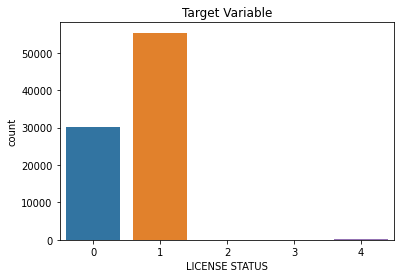

In [103]:
plt.title('Target Variable')
sns.countplot(train_df['LICENSE STATUS'])
plt.show()

Dataset is quite imbalanced and may result in incorrect prediction so before feeding it to our model we first need to balance this data set

In [104]:
train_df["LICENSE STATUS"].value_counts()# 0 = AAC, 1= AAI, 2 = INQ, 3 = REA, 4 = REV

1    55400
0    30200
4      290
3        3
2        2
Name: LICENSE STATUS, dtype: int64

In [105]:
X = train_df.drop("LICENSE STATUS", axis = 1)

In [106]:
y = train_df['LICENSE STATUS']

In [107]:
y.value_counts()

1    55400
0    30200
4      290
3        3
2        2
Name: LICENSE STATUS, dtype: int64

Splitting the data for traning and testing

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [109]:
y_train

4553     1
75659    1
75149    1
49218    0
24484    0
        ..
6265     0
54886    0
76820    1
860      1
15795    1
Name: LICENSE STATUS, Length: 60126, dtype: int32

To create a balanced dataset: Oversampling, using SMOTE

In [110]:
smote = SMOTE(k_neighbors=1)

In [111]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [112]:
Counter(y_train_smote)

Counter({1: 38856, 0: 38856, 4: 38856, 2: 38856, 3: 38856})

c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


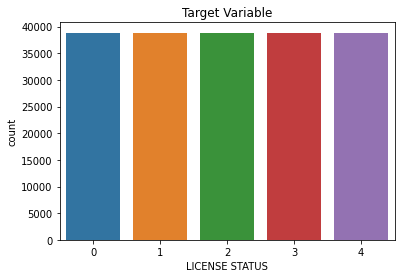

In [113]:
plt.title('Target Variable')
sns.countplot(y_train_smote)
plt.show()

### Feature Selection

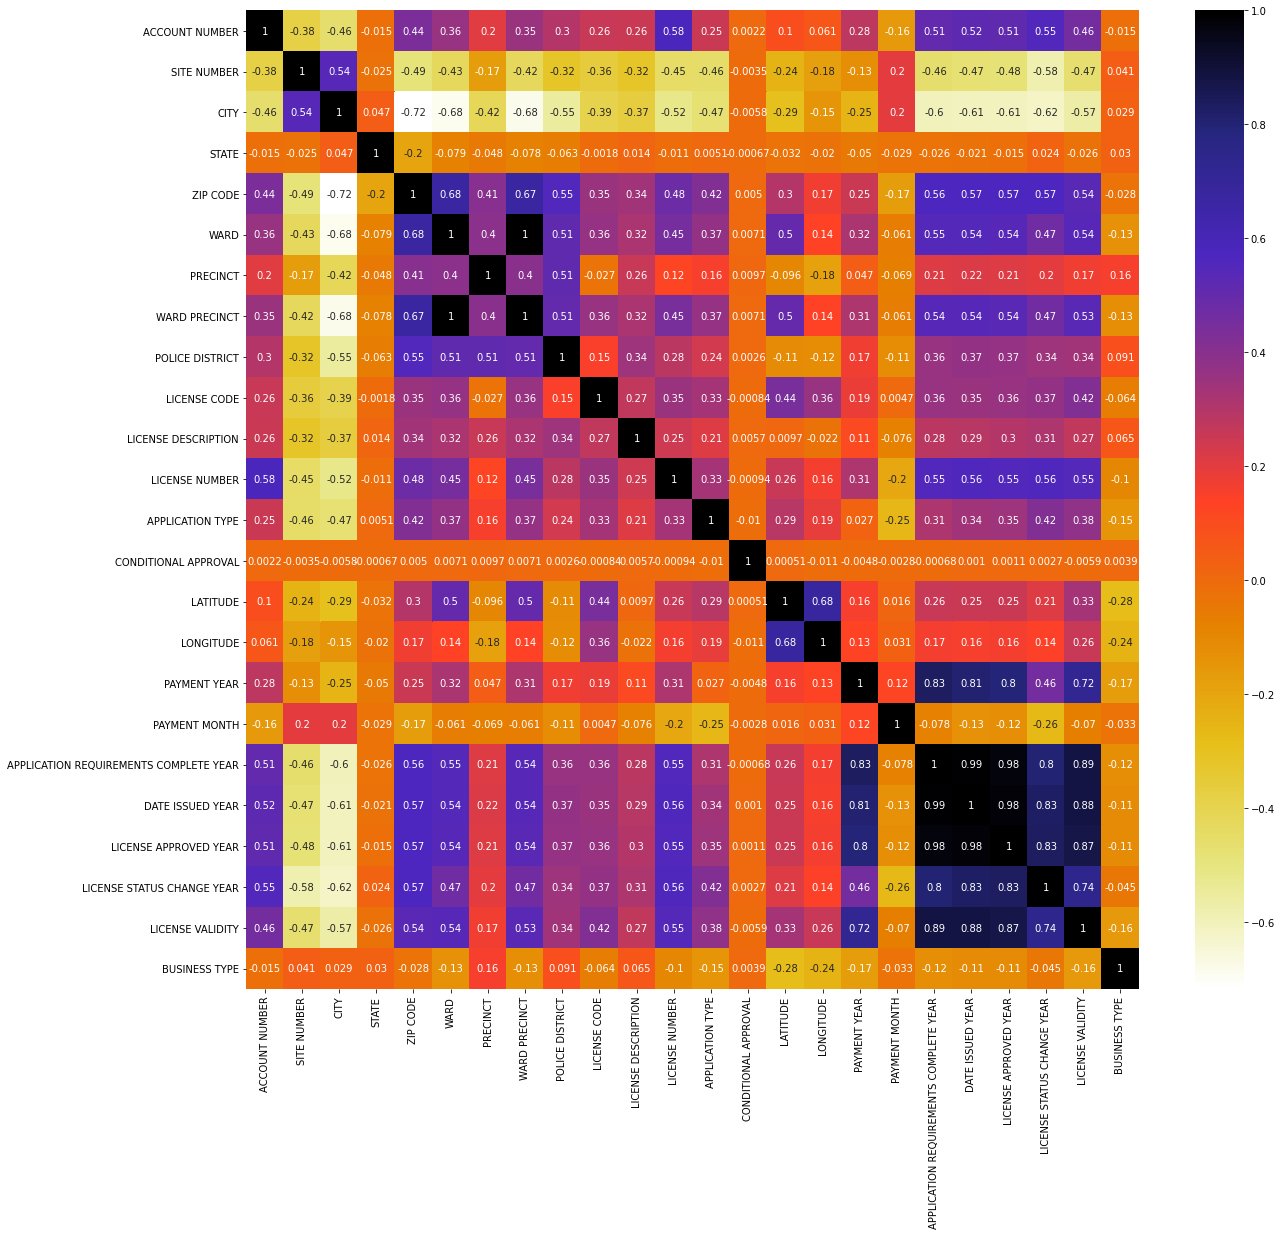

In [114]:
#Finding corelation for feature selection
plt.figure(figsize=(20,18))
cor = X_train_smote.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [115]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [116]:
corr_features = correlation(X_train_smote, 0.8)
len(set(corr_features))

6

In [117]:
corr_features #Highly Corelated Features

{'APPLICATION REQUIREMENTS COMPLETE YEAR',
 'DATE ISSUED YEAR',
 'LICENSE APPROVED YEAR',
 'LICENSE STATUS CHANGE YEAR',
 'LICENSE VALIDITY',
 'WARD PRECINCT'}

Dtermining mutual information for feature selection

In [118]:
mutual_info = mutual_info_classif(X_train_smote, y_train_smote)
mutual_info

array([1.09756966, 0.46435865, 0.76447849, 0.03570487, 1.03423002,
       0.77508666, 0.83234762, 0.88879986, 0.84654408, 0.81303307,
       0.92906816, 0.91369242, 0.31430142, 0.00125273, 0.83444949,
       0.79768417, 0.77890631, 0.46050069, 0.78320386, 0.7926139 ,
       0.76554841, 1.0997703 , 0.39689971, 0.4423116 ])

In [119]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_smote.columns
mutual_info.sort_values(ascending=False)

LICENSE STATUS CHANGE YEAR    1.099770
ACCOUNT NUMBER                1.097570
ZIP CODE                      1.034230
LICENSE DESCRIPTION           0.929068
LICENSE NUMBER                0.913692
                                ...   
BUSINESS TYPE                 0.442312
LICENSE VALIDITY              0.396900
APPLICATION TYPE              0.314301
STATE                         0.035705
CONDITIONAL APPROVAL          0.001253
Length: 24, dtype: float64

<AxesSubplot:>

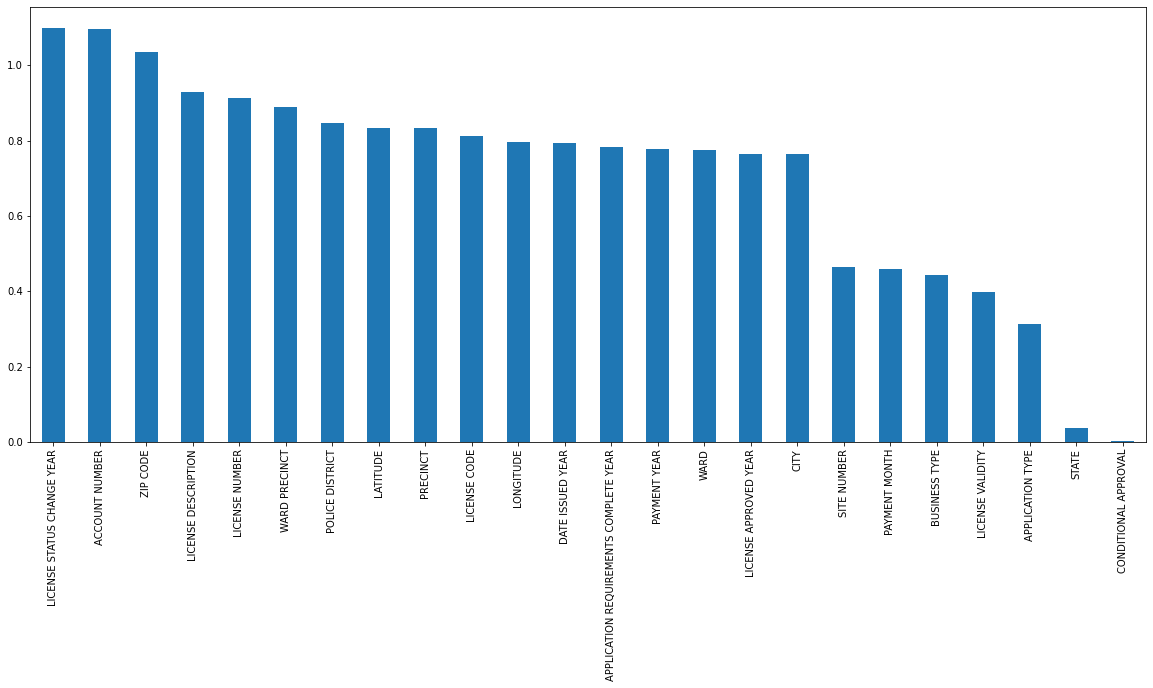

In [120]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [121]:
#Select top 10 important features
sel_ten_cols = SelectKBest(mutual_info_classif, k=10)
sel_ten_cols.fit(X_train_smote, y_train_smote)
X_train_smote.columns[sel_ten_cols.get_support()]

Index(['ACCOUNT NUMBER', 'ZIP CODE', 'PRECINCT', 'WARD PRECINCT',
       'POLICE DISTRICT', 'LICENSE CODE', 'LICENSE DESCRIPTION',
       'LICENSE NUMBER', 'LATITUDE', 'LICENSE STATUS CHANGE YEAR'],
      dtype='object')

In [122]:
final_X_train_smote = X_train_smote[['ACCOUNT NUMBER', 'ZIP CODE', 'PRECINCT', 'WARD PRECINCT',
       'POLICE DISTRICT', 'LICENSE CODE', 'LICENSE DESCRIPTION',
       'LICENSE NUMBER', 'LATITUDE', 'LICENSE STATUS CHANGE YEAR']]

In [123]:
final_X_test = X_test[['ACCOUNT NUMBER', 'ZIP CODE', 'PRECINCT', 'WARD PRECINCT',
       'POLICE DISTRICT', 'LICENSE CODE', 'LICENSE DESCRIPTION',
       'LICENSE NUMBER', 'LATITUDE', 'LICENSE STATUS CHANGE YEAR']]

## XGBoost

In [124]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20] ,
 "max_depth"        : [ 3, 4, 5, 6],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],    
}

In [125]:
classifier=xgboost.XGBClassifier()

In [126]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [127]:
random_search.fit(final_X_train_smote,y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning
c:\users\siddhesh\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:47:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None,
                           

In [128]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [129]:
classifier = random_search.best_estimator_

In [130]:
classifier.fit(final_X_train_smote, y_train_smote)

[20:48:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [131]:
y_pred_xgb = classifier.predict(final_X_test)

In [132]:
acc_xgb = round( metrics.accuracy_score(y_test, y_pred_xgb) * 100 , 2 )
print( 'Total Accuracy : ', acc_xgb )

Total Accuracy :  94.36


In [133]:
# Create confusion matrix function to find out sensitivity and specificity
def draw_cm(actual, predicted):
    cm = confusion_matrix( actual, predicted, [1,0]).T
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["Yes","No"] , yticklabels = ["Yes","No"] )
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.show()

C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[1, 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


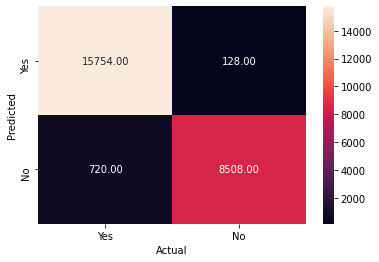

In [134]:
#Confusion Matrix
draw_cm(y_test, y_pred_xgb)

## KNN Classifier

In [135]:
# Create a KNN Classifier
knn = KNeighborsClassifier()

In [136]:
parameters = {'n_neighbors': [3, 4, 5, 10], 
              'weights': ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size' : [10, 20, 30, 50]
             }

In [137]:
random_search=RandomizedSearchCV(knn,param_distributions=parameters,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [138]:
random_search.fit(final_X_train_smote,y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 50],
                                        'n_neighbors': [3, 4, 5, 10],
                                        'weights': ['uniform', 'distance']},
                   scoring='roc_auc', verbose=3)

In [139]:
random_search.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=20)

In [140]:
knn = random_search.best_estimator_

In [141]:
knn.fit(final_X_train_smote, y_train_smote)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=20)

In [142]:
y_pred_knn = knn.predict(final_X_test)

In [143]:
acc_knn = round( metrics.accuracy_score(y_test, y_pred_knn) * 100 , 2 )
print( 'Total Accuracy : ', acc_knn )

Total Accuracy :  82.41


C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[1, 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


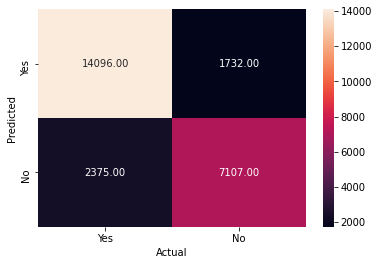

In [144]:
draw_cm(y_test, y_pred_knn)

## Logistic Regression

In [145]:
# Create a Logistic regression classifier
logreg = LogisticRegression()

# Train the model using the training sets 
logreg.fit(final_X_train_smote, y_train_smote)

C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [146]:
y_pred = logreg.predict(final_X_test)

In [147]:
acc_logreg = round( metrics.accuracy_score(y_test, y_pred) * 100, 2 )
print( 'Total Accuracy : ', acc_logreg )

Total Accuracy :  46.49


C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[1, 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


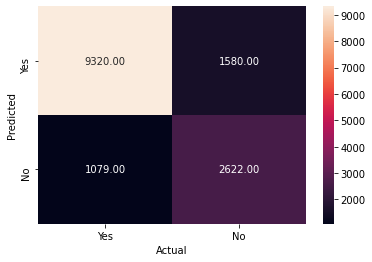

In [148]:
draw_cm(y_test, y_pred)

## Naive Bayes

In [149]:
model = GaussianNB()

In [150]:
model.fit(final_X_train_smote,y_train_smote)

GaussianNB()

In [151]:
y_pred_gnb = model.predict(final_X_test)

In [152]:
acc_nb = round( metrics.accuracy_score(y_test, y_pred_gnb) * 100, 2 )
print( 'Total Accuracy : ', acc_nb )

Total Accuracy :  72.46


## Decision Tree

In [153]:
clf = DecisionTreeClassifier()

In [154]:
dt_parameters = [{'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10, 50], 
              'min_samples_split': [2, 3, 50, 100],
              'min_samples_leaf': [1, 5, 8, 10]
             }]

In [155]:
random_search=RandomizedSearchCV(clf,param_distributions=dt_parameters,n_iter=3,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)

In [156]:
random_search.fit(final_X_train_smote,y_train_smote)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  category=UserWarning


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=3,
                   n_jobs=-1,
                   param_distributions=[{'criterion': ['entropy', 'gini'],
                                         'max_depth': [2, 3, 5, 10, 50],
                                         'max_features': ['log2', 'sqrt',
                                                          'auto'],
                                         'min_samples_leaf': [1, 5, 8, 10],
                                         'min_samples_split': [2, 3, 50, 100]}],
                   scoring='roc_auc', verbose=3)

In [157]:
random_search.best_estimator_

DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=3)

In [158]:
clf = random_search.best_estimator_

In [159]:
clf.fit(final_X_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=8,
                       min_samples_split=3)

In [160]:
y_pred_dt = clf.predict(final_X_test)

In [161]:
acc_dt = round( metrics.accuracy_score(y_test, y_pred_dt) * 100 , 2 )
print( 'Total Accuracy : ', acc_dt )

Total Accuracy :  75.82


C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[1, 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


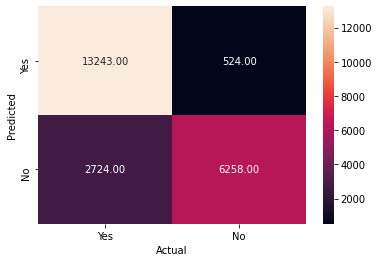

In [162]:
draw_cm(y_test, y_pred_dt)

## Random Forest

In [163]:
rf = RandomForestClassifier()

In [164]:
parameters_rf = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

In [165]:
random_search=RandomizedSearchCV(rf,param_distributions=parameters_rf,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(final_X_train_smote,y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  category=UserWarning


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 10],
                                        'max_features': ['log2', 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [1, 5, 8],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [4, 6, 9, 10, 15]},
                   scoring='roc_auc', verbose=3)

In [166]:
random_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=8, n_estimators=10)

In [167]:
rf = random_search.best_estimator_

In [168]:
rf.fit(final_X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=10, min_samples_leaf=8, n_estimators=10)

In [169]:
y_pred_rf = rf.predict(final_X_test)

In [170]:
acc_rf = round( metrics.accuracy_score(y_test, y_pred_rf) * 100 , 2 )
print( 'Total Accuracy : ', acc_rf )

Total Accuracy :  95.08


C:\Users\Siddhesh\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass labels=[1, 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


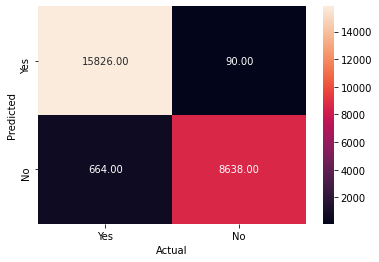

In [171]:
draw_cm(y_test, y_pred_rf)

### Compare Models

In [172]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 
              'K - Nearest Neighbors', 'XGBoost'],
    'Score': [acc_logreg, acc_nb, acc_dt, acc_rf,acc_knn, acc_xgb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,95.08
5,XGBoost,94.36
4,K - Nearest Neighbors,82.41
2,Decision Tree,75.82
1,Naive Bayes,72.46
0,Logistic Regression,46.49


XGBoost outperforms other models and hence it will be used for our final prediction

## Final Prediction

In [173]:
new_test_df = test_df[['ACCOUNT NUMBER', 'ZIP CODE', 'PRECINCT', 'WARD PRECINCT',
       'POLICE DISTRICT', 'LICENSE CODE', 'LICENSE DESCRIPTION',
       'LICENSE NUMBER', 'LATITUDE', 'LICENSE STATUS CHANGE YEAR']]

In [174]:
final_pred = classifier.predict(new_test_df)

In [175]:
Final_Predict['LICENSE STATUS'] = final_pred

In [176]:
Final_Predict.shape

(57239, 2)

In [177]:
Final_Predict

,ID,LICENSE STATUS
85902,1516615-20120216,0
85903,69813-20110616,0
85904,1519227-20041116,0
85905,1922025-20100816,0
85906,1675683-20070816,0
...,...,...
143136,1743194-20070816,0
143137,2032383-20160716,0
143138,40376-20020216,0
143139,2064176-20121116,0


In [178]:
# 0 = AAC, 1= AAI, 2 = INQ, 3 = REA, 4 = REV
Final_Predict['LICENSE STATUS'] = Final_Predict['LICENSE STATUS'].replace(0, 'AAC')
Final_Predict['LICENSE STATUS'] = Final_Predict['LICENSE STATUS'].replace(1, 'AAI')
Final_Predict['LICENSE STATUS'] = Final_Predict['LICENSE STATUS'].replace(2, 'INQ')
Final_Predict['LICENSE STATUS'] = Final_Predict['LICENSE STATUS'].replace(3, 'REA')
Final_Predict['LICENSE STATUS'] = Final_Predict['LICENSE STATUS'].replace(4, 'REV')

In [179]:
Final_Predict['LICENSE STATUS'].value_counts()

AAC    53397
REV     3611
AAI      231
Name: LICENSE STATUS, dtype: int64

In [180]:
Final_Predict.to_csv('Final_Prediction.csv', index=False)